In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [34]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse

from scipy import stats

from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [5]:
class Markov:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.predictions = self.model.predict(X)
        self.errors = self.y - self.predictions
        self.X_const = sm.add_constant(X)
        self.lm_results = sm.OLS(y, self.X_const).fit()
        self.coefs = self.model.coef_
        self.intercepts = self.model.intercept_

    def plot_linearity(self):
        count = 1
        plt.figure(figsize=(25, 15))
        for col in self.X.columns:
            plt.subplot(len(cols) / 3, len(cols) / 3, count)
            plt.scatter(self.X[col], self.predictions)
            plt.xlabel(col)
            plt.ylabel("target")
            count += 1

        plt.tight_layout()
        plt.show()

    def plot_homoscedasticity(self):
        plt.scatter(self.predictions, self.errors)
        plt.xlabel("Predicted")
        plt.ylabel("Residual")
        plt.axhline(y=0)
        plt.title("Residual vs. Predicted")
        plt.show()

    def b_pagan(self):
        _, lmp, _, fp = het_breuschpagan(lm_results.resid, X)

        return lmp, fp

    def get_vifs(self):
        vifs = []
        for i in range(X_const.shape[1]):
            vif = variance_inflation_factor(X_const.values, i)
            vifs.append(vif)

        return pd.Series(vifs, index=X_const.columns)

    def plot_errors(self):
        plt.plot(self.errors)
        plt.show()

    def plot_errors_acf(self):
        acf_data = acf(self.errors)

        plt.plot(acf_data[1:])
        plt.show()

    def plot_error_normality(self):
        qqplot(lm_results.resid, line="s")
        plt.show()

        plt.hist(lm_results.resid)
        plt.show()

    def shapiro_wilkes(self):
        return stats.shapiro(self.lm_results.resid)

<IPython.core.display.Javascript object>

In [6]:
def clean_house_prices_df(house_prices_df):
    house_prices_df = house_prices_df.set_index("id")

    # Log transfrom dataframe
    log_df = house_prices_df.copy()
    log_df["log_saleprice"] = np.log(log_df["saleprice"])
    log_df = log_df.drop(columns=["saleprice"])

    # Keep only top correlated columns
    corr_df = log_df.corr()[["log_saleprice"]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()
    top_corrs = corr_df.sort_values("abs_corr", ascending=False).head(10)
    num_cols = log_df.select_dtypes("number").columns
    keep_cols = top_corrs.index
    drop_cols = [c for c in num_cols if c not in keep_cols]
    log_df = log_df.drop(columns=drop_cols)
    log_df

    drop_cols = ["poolqc", "alley", "fence", "fireplacequ", "miscfeature"]
    log_df = log_df.drop(columns=drop_cols)
    log_df = log_df.dropna()

    cat_cols = log_df.select_dtypes("O").copy()
    keep_cols = ["exterqual", "bsmtqual", "kitchenqual", "centralair"]
    drop_cols = [c for c in cat_cols.columns if c not in keep_cols]

    log_df = log_df.drop(columns=drop_cols)

    # Encode centralair as binary
    log_df["centralair"] = (log_df["centralair"] == "Y").astype(int)

    # Encode qual columns as ordinal
    quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
    log_df[["exterqual", "bsmtqual", "kitchenqual"]] = log_df[
        ["exterqual", "bsmtqual", "kitchenqual"]
    ].replace(quality_map)
    
    log_df= log_df.drop(columns=["fullbath", "garagearea", "totalbsmtsf", "exterqual"])

    return log_df


<IPython.core.display.Javascript object>

In [8]:
warnings.filterwarnings("ignore")

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
house_prices_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [11]:
houses = clean_house_prices_df(house_prices_df)
houses

,overallqual,yearbuilt,yearremodadd,bsmtqual,centralair,firstflrsf,grlivarea,kitchenqual,garagecars,log_saleprice
id,,,,,,,,,,
1,7,2003,2003,3,1,856,1710,3,2,12.247694
2,6,1976,1976,3,1,1262,1262,2,2,12.109011
3,7,2001,2002,3,1,920,1786,3,2,12.317167
4,7,1915,1970,2,1,961,1717,3,3,11.849398
5,8,2000,2000,3,1,1145,2198,3,3,12.429216
...,...,...,...,...,...,...,...,...,...,...
1456,6,1999,2000,3,1,953,1647,2,2,12.072541
1457,6,1978,1988,3,1,2073,2073,2,2,12.254863
1458,7,1941,2006,2,1,1188,2340,3,1,12.493130


<IPython.core.display.Javascript object>

In [53]:
X = houses.drop(columns=["log_saleprice"])
y = houses["log_saleprice"]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<IPython.core.display.Javascript object>

In [54]:
lm_results = sm.OLS(y_train, X_train).fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     560.7
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:44:55   Log-Likelihood:                 454.30
No. Observations:                1070   AIC:                            -888.6
Df Residuals:                    1060   BIC:                            -838.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.6586      0.754      8.835      0.000       5.180       8.137
overallqual      0.0753      0.006     11.771      0.000       0.063       0.088
yearbuilt        0.0006      0.000      2.120      0.034    4.51e-05       0.001
yearremodadd     0.0013      0.000      3.751      0.000       0.001       0.002
bsmtqual         0.0513      0.012      4.256      0.000       0.028       0.075
centralair       0.2201      0.026      8.339      0.000       0.168       0.272
firstflrsf       0.0001   1.58e-05      7.656      0.000    8.97e-05       0.000
grlivarea        0.0002   1.32e-05     17.607      0.000       0.000       0.000
kitchenqual      0.0566      0.011      4.989      0.000       0.034       0.079
garagecars       0.0775      0.011      7.367      0.000       0.057       0.098
==============================================================================
Omnibus:                      698.839   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26715.326
Skew:                          -2.436   Prob(JB):                         0.00
Kurtosis:                      26.989   Cond. No.                     5.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

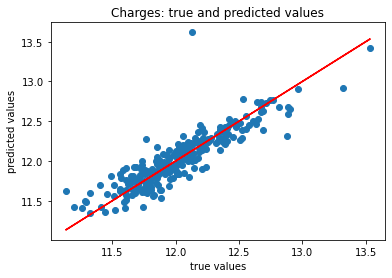

,evaluators,values
0,mae,0.113693
1,mse,0.029106
2,rmse,0.170605
3,mape,0.947434


<IPython.core.display.Javascript object>

In [56]:
y_pred = lm_results.predict(X_test)
y_true = y_test
plt.scatter(y_true, y_pred)
plt.plot(y_true, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

evaluators = ["mae", "mse", "rmse", "mape"]
evaluations = [
    mean_absolute_error(y_true, y_pred),
    mse(y_true, y_pred),
    rmse(y_true, y_pred),
    np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
]
evaluation_df = pd.DataFrame({"evaluators": evaluators, "values": evaluations})
evaluation_df

In [43]:
evaluation_df["unlogged"] = np.exp(evaluation_df["values"])
evaluation_df

,evaluators,values,unlogged
0,mae,1.789937e+05,inf
1,mse,3.806802e+10,inf
2,rmse,1.951103e+05,inf
3,mape,1.475186e+06,inf


<IPython.core.display.Javascript object>